In [0]:
import numpy as np

In [0]:
!alias java='java -XmX2g'

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget http://apache.osuosl.org/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

--2019-06-09 20:32:02--  http://apache.osuosl.org/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
Resolving apache.osuosl.org (apache.osuosl.org)... 64.50.233.100, 140.211.166.134, 64.50.236.52, ...
Connecting to apache.osuosl.org (apache.osuosl.org)|64.50.233.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229988313 (219M) [application/x-gzip]
Saving to: ‘spark-2.4.3-bin-hadoop2.7.tgz’

spark-2.4.3-bin-had 100%[===================>] 219.33M  39.4MB/s    in 6.2s    

2019-06-09 20:32:08 (35.7 MB/s) - ‘spark-2.4.3-bin-hadoop2.7.tgz’ saved [229988313/229988313]



In [4]:
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 215.6MB 74kB/s 
     |████████████████████████████████| 204kB 32.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [0]:
DATA_PATH = "/content/gdrive/My Drive/Colab Dataset/reviews_Digital_Music_5.json.gz" 
APP_NAME = "Sentiment Analysis"
SPARK_URL = "local[*]"
MAX_MEMORY = "3g"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).getOrCreate()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [0]:
df = sqlContext.read.json(DATA_PATH)

In [10]:
print(f"Dataset shape is {df.count():d} rows by {len(df.columns):d} columns.")

Dataset shape is 64706 rows by 9 columns.


In [11]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [12]:
df.registerTempTable('reviews')
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|      35580|
|    4.0|      16536|
|    3.0|       6789|
|    2.0|       3010|
|    1.0|       2791|
+-------+-----------+



In [0]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())
df = df.withColumn("overall_recode", udf(df.overall))

([<matplotlib.axis.XTick at 0x7f561468b0b8>,
 <a list of 2 Text xticklabel objects>)

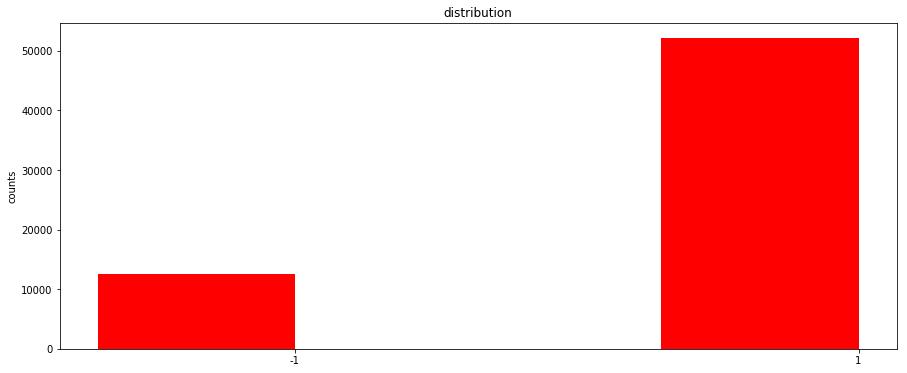

In [14]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = df.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [15]:
df.select("overall", "overall_recode", "summary", "reviewText").show(5)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    5.0|             1|Enya's last great...|It's hard to beli...|
|    5.0|             1|Enya at her most ...|A clasically-styl...|
|    5.0|             1|     The best so far|I never thought E...|
|    5.0|             1|Ireland produces ...|This is the third...|
|    4.0|             1|4.5; music to dre...|Enya, despite bei...|
+-------+--------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import Tokenizer, Word2Vec
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(df)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [17]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [18]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|             1|It's hard to beli...|[it's, hard, to, ...|[-0.0788386127442...|
|             1|A clasically-styl...|[a, clasically-st...|[-0.0440800798287...|
|             1|I never thought E...|[i, never, though...|[-0.0615663781105...|
|             1|This is the third...|[this, is, the, t...|[-0.0684642166102...|
|             1|Enya, despite bei...|[enya,, despite, ...|[-0.0547428752579...|
|             1|Who knows why I i...|[who, knows, why,...|[-0.0607233263266...|
|            -1|Enya is one of a ...|[enya, is, one, o...|[-0.0518587913960...|
|             1|Enya is one of of...|[enya, is, one, o...|[-0.0569693655898...|
|             1|This is not anoth...|[this, is, not, a...|[-0.0557375374408...|
|             1|Many times, AND W...|[ma

In [0]:

labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)


featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    

(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])


rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [21]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.199985
Accuracy = 0.800015
